Train a Vision Transformer for small datasets with Reconstructed Images from CVAE

In [1]:
!nvidia-smi

Mon Feb 17 09:24:12 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   55C    P8              13W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Importing libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, ops
from keras.models import Model
from tensorflow.keras.optimizers import Adam, AdamW

import sklearn.metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

Data Loading and Preprocessing

In [4]:
base_dir = 'https://console.cloud.google.com/storage/browser/adni-mri-bucket?project=aerial-episode-450709-q1'


In [5]:
from google.cloud import storage

# Initialize the storage client
client = storage.Client()

# Access the bucket
bucket_name = 'adni-mri-bucket'
bucket = client.get_bucket(bucket_name)

In [6]:
# Loading Data

categories = ['CN', 'EMCI', 'MCI', 'LMCI', 'AD']
IMAGE_SIZE = 256
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 1)
NUM_CLASSES = 5

# Function to load and preprocess images from GCP bucket
def load_images_from_bucket(bucket, categories):
    data = []
    labels = []
    for category in categories:
        class_num = categories.index(category)
        # Prefix for the image folder in the bucket
        prefix = f'{category}/'
        blobs = bucket.list_blobs(prefix=prefix)  # List all the images in the category folder

        for blob in blobs:
            try:
                # Download the image as bytes
                img_data = blob.download_as_bytes()
                # Decode the image
                img_array = tf.image.decode_image(img_data, channels=1)
                img_array = tf.image.resize(img_array, [IMAGE_SIZE, IMAGE_SIZE])
                img_array = tf.keras.preprocessing.image.img_to_array(img_array)
                data.append(img_array)
                labels.append(class_num)
            except Exception as e:
                print(f"Error loading image {blob.name}: {e}")
    return np.array(data), np.array(labels)


# Loading data from GCP bucket
x_full, y_full = load_images_from_bucket(bucket, categories)
x_full, y_full = shuffle(x_full, y_full)

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.15, random_state=42)

In [7]:
# Shape of x_train, y_train, x_test, y_test

print(f"x_full shape: {x_full.shape} - y_full shape: {y_full.shape}")
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_full shape: (14000, 256, 256, 1) - y_full shape: (14000,)
x_train shape: (11900, 256, 256, 1) - y_train shape: (11900,)
x_test shape: (2100, 256, 256, 1) - y_test shape: (2100,)


In [8]:
# Preprocessing function

def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), IMAGE_SIZE, IMAGE_SIZE, 1))
    return array

In [9]:
# Normalizing and reshaping the data

x_train = preprocess(x_train)
x_test = preprocess(x_test)

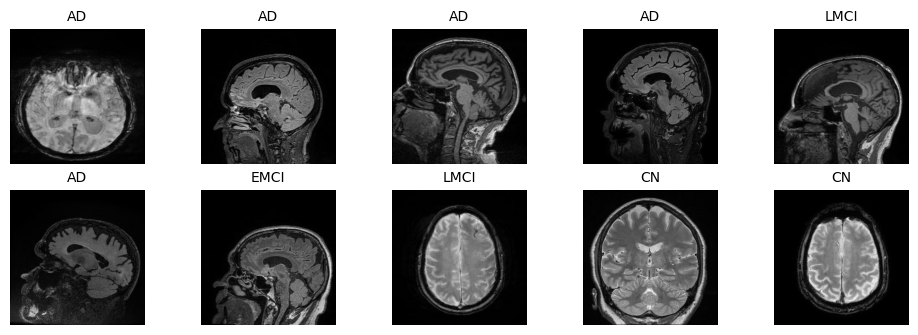

In [10]:
# Displaying the loaded data
n=5
plt.figure(figsize=(10, 4))

# Plot x_train images

for i in range(n):
    # Display x_train
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"{categories[y_train[i]]}", fontsize=10)
    plt.axis("off")

# Plot x_test images
for i in range(n):
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"{categories[y_test[i]]}", fontsize=10)
    plt.axis("off")

plt.subplots_adjust(left=0.05, right=0.95, top=0.85, wspace=0.4)
plt.show()

CVAE

In [11]:
# Creating a sampling layer for the VAE latent space

# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding the image."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [12]:
# Building the CVAE

latent_dim = 64

# Encoder
encoder_inputs = keras.Input(shape=(256, 256, 1))  # Input shape 256x256x1
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)  # Downsample to 128x128x32
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)  # Downsample to 64x64x64
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)  # Downsample to 32x32x128
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)  # Downsample to 16x16x256
x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(x)  # Downsample to 8x8x512
x = layers.Conv2D(1024, 3, activation="relu", strides=2, padding="same")(x)  # Downsample to 4x4x1024

# Variational Encoder component for retrieving latent vector z
x2 = layers.Flatten()(x)  # Flatten to (4*4*1024) = 16384 units
x2 = layers.Dense(512, activation="relu")(x2)  # Dense layer with 512 units

z_mean = layers.Dense(latent_dim, name="z_mean")(x2)  # z_mean for latent space
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x2)  # z_log_var for latent space
z = Sampling()([z_mean, z_log_var])  # Sampling layer using (z_mean, z_log_var)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


# Decoder
x = layers.Conv2DTranspose(1024, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 8x8x1024
x = layers.Conv2DTranspose(512, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 16x16x512
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 32x32x256
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 64x64x128
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 128x128x64
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to 256x256x32
x = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)  # Output layer with shape 256x256x1


# Variational Decoder component For Resizing latent vector z for ViT input
latent_inputs = keras.Input(shape=(latent_dim,))  # Latent space input of size 64
x3 = layers.Dense(4 * 4 * 1024, activation="relu")(latent_inputs)  # Dense layer to match the flattened size from encoder
x3 = layers.Reshape((4, 4, 1024))(x3)                               # Reshape to 4x4x1024
x3 = layers.Conv2DTranspose(1024, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 8x8x1024
x3 = layers.Conv2DTranspose(512, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 16x16x512
x3 = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 32x32x256
x3 = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 64x64x128
x3 = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 128x128x64
x3 = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x3)  # Upsample to 256x256x32
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x3)  # Output layer (256x256x1)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 512)      │      1,180,160 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 4, 4, 1024)     │      4,719,616 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 16384)          │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      8,389,120 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 64)             │         32,832 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 64)             │         32,832 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 64)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,742,400 (56.24 MB)

 Trainable params: 14,742,400 (56.24 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16384)               │       1,064,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 8, 8, 1024)          │       9,438,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 16, 16, 512)         │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 64, 64, 128)         │         295,040 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 128, 128, 64)        │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_12                  │ (None, 256, 256, 32)        │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 256, 256, 1)         │             289 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,789,761 (64.05 MB)

 Trainable params: 16,789,761 (64.05 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Autoencoder for image reconstruction
autoencoder = Model(encoder_inputs, x)

# Compiling the autoencoder
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [14]:
# Training the autoencoder

autoencoder.fit(
    x=x_train,
    y=x_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 114s 769ms/step - accuracy: 0.1558 - loss: 0.5256 - val_accuracy: 0.1602 - val_loss: 0.3719
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 285ms/step - accuracy: 0.1590 - loss: 0.3711 - val_accuracy: 0.1602 - val_loss: 0.3643
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 286ms/step - accuracy: 0.1590 - loss: 0.3639 - val_accuracy: 0.1602 - val_loss: 0.3593
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 284ms/step - accuracy: 0.1590 - loss: 0.3592 - val_accuracy: 0.1602 - val_loss: 0.3554
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 285ms/step - accuracy: 0.1590 - loss: 0.3563 - val_accuracy: 0.1602 - val_loss: 0.3531
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 285ms/step - accuracy: 0.1590 - loss: 0.3542 - val_accuracy: 0.1602 - val_loss: 0.3533
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 286ms/step - accuracy: 0.1590 - loss: 0.3532 - val_accuracy: 0.1602 - val_loss: 0.3508
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 285ms/step - accuracy: 0.1590 - loss: 0.3518 -

66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step


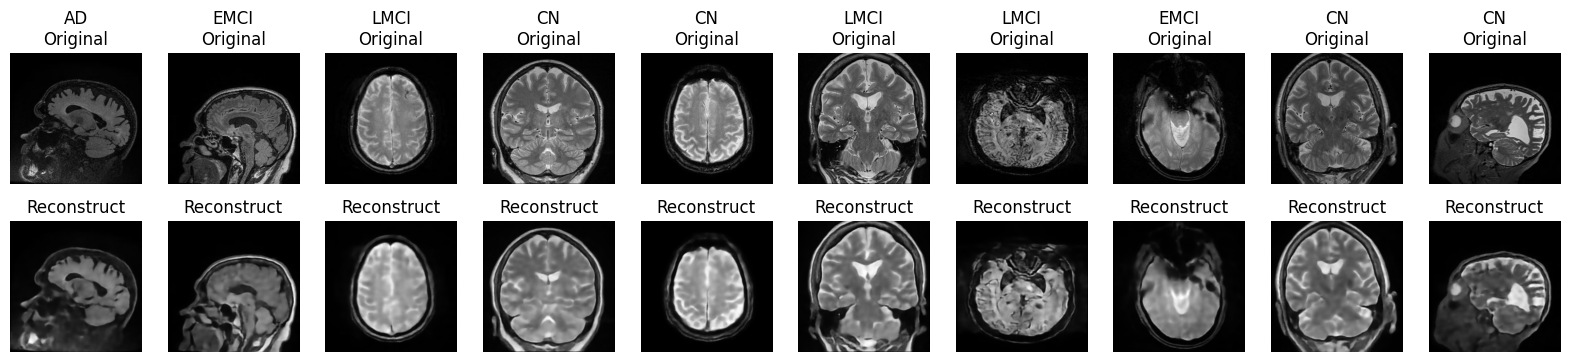

In [15]:
# Evaluating the model on the test set
ae_predictions = autoencoder.predict(x_test)

n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Display original x_test
    ax = plt.subplot(2, n, i + 1)
    plt.imshow((x_test[i] / 255.0))
    plt.gray()
    plt.title(categories[y_test[i]] + "\nOriginal", fontsize=12)
    plt.axis("off")

    # Display reconstructed x_test
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(ae_predictions[i])
    plt.gray()
    plt.title("Reconstruct", fontsize=12)
    plt.axis("off")

plt.show()

In [16]:
# Reconstructing x_train
reconstructed_x_train = autoencoder.predict(x_train)
reconstructed_x_train.shape

372/372 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step


(11900, 256, 256, 1)

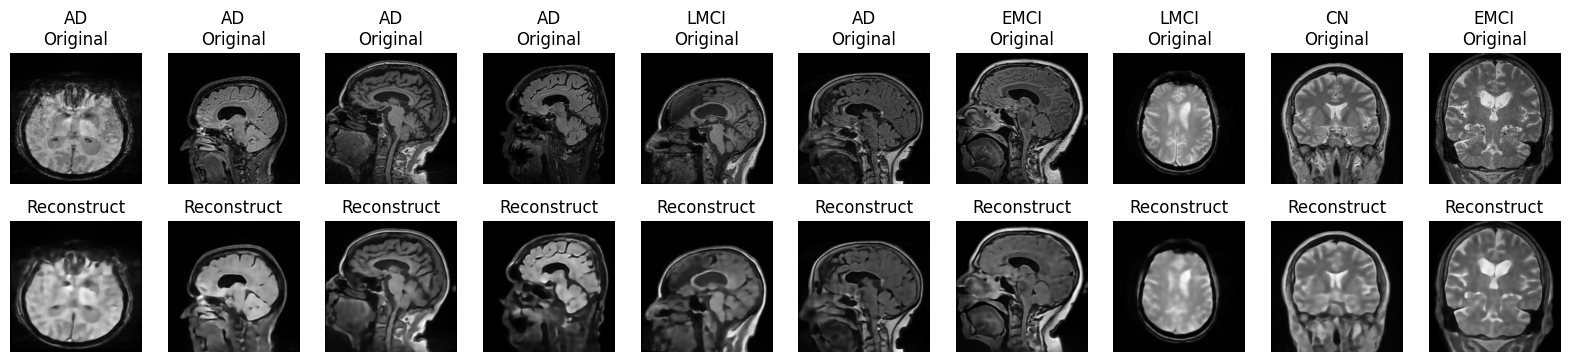

In [46]:
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Display original x_train
    ax = plt.subplot(2, n, i + 1)
    plt.imshow((x_train[i] / 255.0))
    plt.gray()
    plt.title(categories[y_train[i]] + "\nOriginal", fontsize=12)
    plt.axis("off")

    # Display reconstructed x_train
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_x_train[i])
    plt.gray()
    plt.title("Reconstruct", fontsize=12)
    plt.axis("off")

plt.show()

ViT

In [18]:
# Configuring Hyperparameters

INPUT_SHAPE = (256, 256, 1)

# Augmentation
IMAGE_SIZE = 256
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# Optimizer
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# Training
EPOCHS = 400
BATCH_SIZE = 256
BUFFER_SIZE = 512

# Architecture
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

In [19]:
# Data augmentation

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(reconstructed_x_train)


In [20]:
# Implementing Shifted Patch Tokenization

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patch embed the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)


ORIGINAL


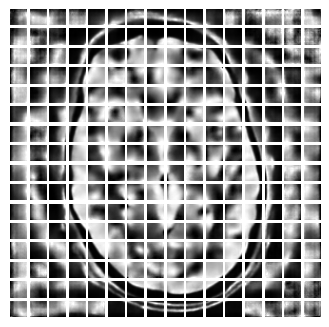

LEFT-UP


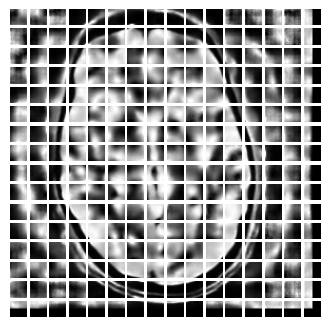

LEFT-DOWN


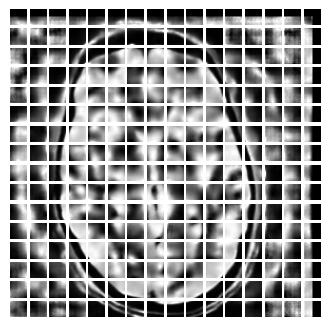

RIGHT-UP


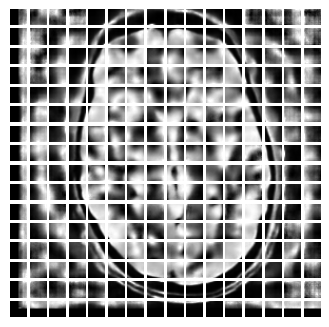

RIGHT-DOWN


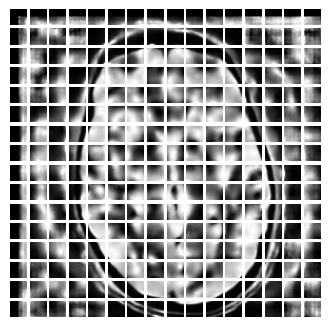

In [21]:
# Visualizing the patches

# Geting a random image and resizing it
image = reconstructed_x_train[np.random.choice(range(reconstructed_x_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

# This takes an image and divides into patches as in the original ViT paper
# (token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
# (token, patch) = (token[0], patch[0])
# n = patch.shape[0]
# count = 1
# plt.figure(figsize=(4, 4))
# for row in range(n):
#     for col in range(n):
#         plt.subplot(n, n, count)
#         count = count + 1
#         image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 1))  # Grayscale: 1 channel
#         plt.imshow(image)
#         plt.axis("off")
# plt.show()

# Shifted Patch Tokenization: This layer takes the image,
# shifts it diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 1))  # Grayscale: 1 channel
            plt.imshow(image[..., index], cmap='gray')  # Plot in grayscale
            plt.axis("off")
    plt.show()


In [22]:
# Implementing the positional embedding on encoded patches

class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches


In [23]:
# Implementing Multi-Head Self Attention function - locally inside the Vit Transfomer Encoder

class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # The initial value is the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores


In [24]:
# Implementing the MLP function - for Transformer Encoder and final classifier

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Building the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)


In [25]:
# Defining the function for the ViT classifier

def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)

    augmented = data_augmentation(inputs)       # Augmenting data

    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)      # Creating patches

    encoded_patches = PatchEncoder()(tokens)        # Encoding patches with positions

    # Create multiple layers of the Transformer block
    for _ in range(TRANSFORMER_LAYERS):

        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)   # Layer normalization 1

        # Creating a multi-head attention layer
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)

        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Creating a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Adding MLP
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)

    # Dense layer for classifying outputs
    logits = layers.Dense(NUM_CLASSES)(features)

    # Creating the Keras model
    model = keras.Model(inputs=inputs, outputs=logits)

    return model


In [26]:
# Creating the ViT classifier, Compiling and Training the ViT with reconstructed_x_train using KFold for cross-validation with 5 folds


# Parameters for K-fold cross-validation
NUM_FOLDS = 5
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

# Store the accuracy for each fold
cv_accuracies = []
histories = []

for fold, (train_idx, val_idx) in enumerate(kf.split(reconstructed_x_train, y_train)):
    print(f"\n--- Fold {fold + 1} ---")

    # Split the data for the current fold
    x_fold_train, y_fold_train = reconstructed_x_train[train_idx], y_train[train_idx]
    # If n_splits=5, 20% of the data is used for validation in each fold, and 80% for training
    x_fold_val, y_fold_val = reconstructed_x_train[val_idx], y_train[val_idx]

    # Create a new model for each fold (necessary to reset weights)
    vit = create_vit_classifier(vanilla=False)

    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    vit.compile(
        optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    )

    # Train the model on the current fold
    history = vit.fit(
        x_fold_train,
        y_fold_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(x_fold_val, y_fold_val),
        verbose=0  # Suppress training output for cleaner logs
    )

    # Store the history object
    histories.append(history.history)

    # Evaluate the fold's model on the validation set
    val_accuracy = vit.evaluate(x_fold_val, y_fold_val, verbose=0)[1]
    cv_accuracies.append(val_accuracy)

    print(f"Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}")

# Report the final cross-validation accuracy results
mean_accuracy = np.mean(cv_accuracies)
std_dev_accuracy = np.std(cv_accuracies)

print(f"\nCross-Validation Mean Accuracy: {mean_accuracy:.4f}")
print(f"Cross-Validation Accuracy Standard Deviation: {std_dev_accuracy:.4f}")


--- Fold 1 ---
Validation Accuracy for Fold 1: 0.9324

--- Fold 2 ---
Validation Accuracy for Fold 2: 0.9286

--- Fold 3 ---
Validation Accuracy for Fold 3: 0.9231

--- Fold 4 ---
Validation Accuracy for Fold 4: 0.9290

--- Fold 5 ---
Validation Accuracy for Fold 5: 0.9252

Cross-Validation Mean Accuracy: 0.9276
Cross-Validation Accuracy Standard Deviation: 0.0032


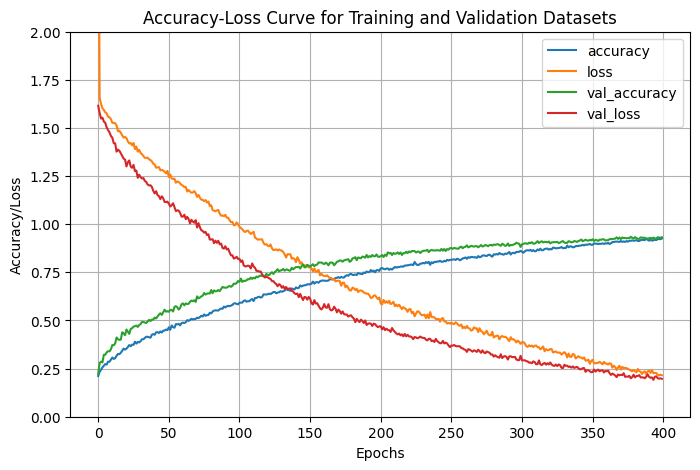

In [29]:
# Accuracy/Loss Curve

fold_idx = 0    # Specify which fold to visualize
history = histories[fold_idx]

pd.DataFrame(history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.title('Accuracy-Loss Curve for Training and Validation Datasets')
plt.show()

In [30]:
# Evaluating the model on the test set

# Accuracy and loss for the test dataset
test_loss, test_acc = vit.evaluate(x_test, y_test)

print('\nAccuracy for Test Dataset: %.4f' % test_acc)
print('\nLoss for Test Dataset: %.4f' % test_loss)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8797 - loss: 0.3492

Accuracy for Test Dataset: 0.8867

Loss for Test Dataset: 0.3280


In [31]:
# Getting predictions for test data (getting the highest probability class)

y_pred_probs = vit.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=-1)

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step



Classification Report: 
               precision    recall  f1-score   support

          CN       0.93      0.87      0.90       454
        EMCI       0.88      0.87      0.88       423
         MCI       0.85      0.92      0.89       425
        LMCI       0.89      0.88      0.89       384
          AD       0.89      0.89      0.89       414

    accuracy                           0.89      2100
   macro avg       0.89      0.89      0.89      2100
weighted avg       0.89      0.89      0.89      2100



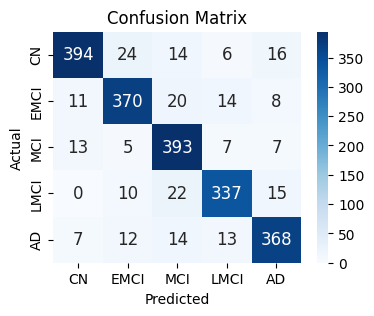

In [32]:
# Classification report
print("\nClassification Report: \n", classification_report(y_test, y_pred, target_names=categories))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12}, xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [33]:
# Compute Sensitivity and Specificity from confusion matrix

# Initialize lists to store results
sensitivity = []
specificity = []

# Calculate metrics for each class
for i in range(len(categories)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)

    sens = TP / (TP + FN) if (TP + FN) > 0 else 0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity.append(sens)
    specificity.append(spec)

# Display results
for idx, category in enumerate(categories):
    print(f"{category} - Sensitivity: {sensitivity[idx]:.2f}, Specificity: {specificity[idx]:.2f}")

CN - Sensitivity: 0.87, Specificity: 0.98
EMCI - Sensitivity: 0.87, Specificity: 0.97
MCI - Sensitivity: 0.92, Specificity: 0.96
LMCI - Sensitivity: 0.88, Specificity: 0.98
AD - Sensitivity: 0.89, Specificity: 0.97


In [37]:
# AUC-ROC Curve

# Convert y_test to a one-hot encoding
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

# Calculate AUC for each class
auc_values = []
for i in range(y_test_binarized.shape[1]):
    auc = roc_auc_score(y_test_binarized[:, i], y_pred_probs[:, i])
    auc_values.append(auc)

# Display per-class AUC
for class_idx, auc_val in enumerate(auc_values):
    print(f"AUC for class {class_idx}: {auc:.4f}")

# Optionally calculate the macro-average AUC
macro_auc = np.mean(auc_values)
print(f"Macro-average AUC: {macro_auc:.4f}")


AUC for class 0: 0.9764
AUC for class 1: 0.9764
AUC for class 2: 0.9764
AUC for class 3: 0.9764
AUC for class 4: 0.9764
Macro-average AUC: 0.9780


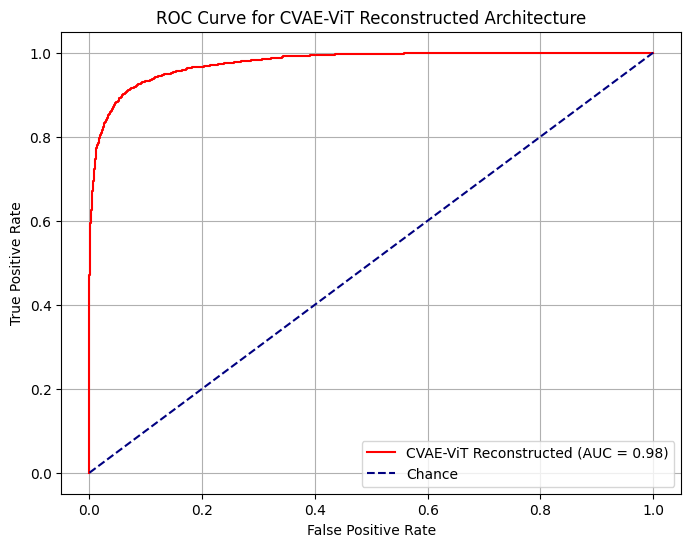

In [47]:
from sklearn.metrics import auc

# Calculate ROC and AUC for the model
fpr_c, tpr_c, _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
auc_c = auc(fpr_c, tpr_c)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_c, tpr_c, color="red", label=f"CVAE-ViT Reconstructed (AUC = {auc_c:.2f})")

# Add a diagonal line for reference
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label="Chance")

# Add labels, legend, and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for CVAE-ViT Reconstructed Architecture")
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()

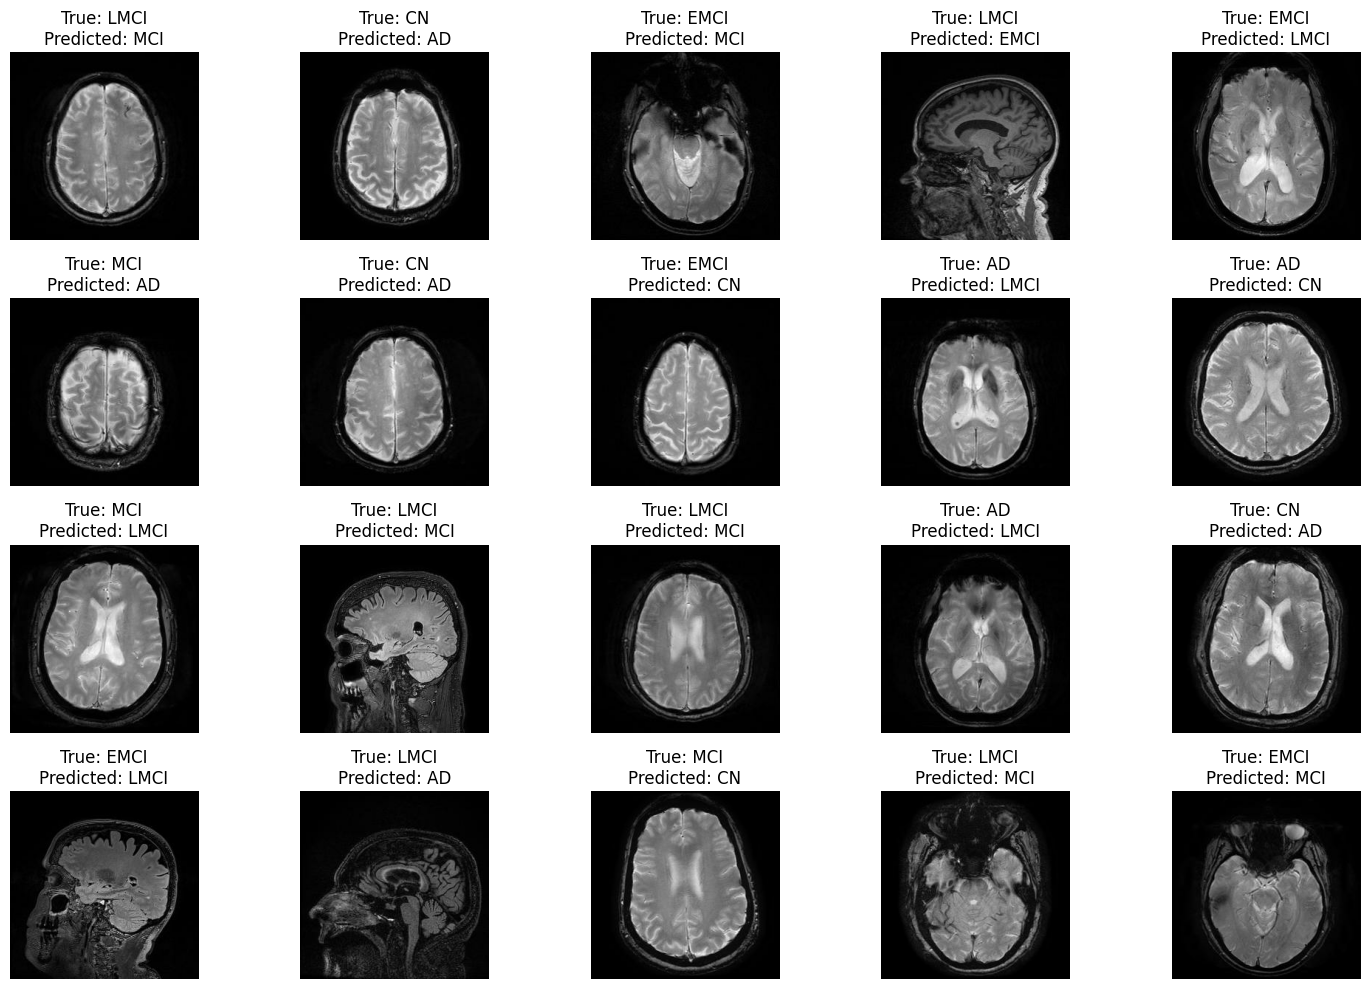

In [39]:
# Displaying the first 20 incorrect predictions

# Finding indices of incorrect predictions
incorrect_indices = np.where(y_pred != y_test)[0]

# Displaying the incorrect predictions
num_incorrect_to_display = min(20, len(incorrect_indices))

plt.figure(figsize=(15, 10))
for i, incorrect_idx in enumerate(incorrect_indices[:num_incorrect_to_display]):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_test[incorrect_idx])
    plt.gray()
    plt.title(f"True: {categories[y_test[incorrect_idx]]}\nPredicted: {categories[y_pred[incorrect_idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [48]:
from google.colab import files

# Save the model temporarily in Colab
model_path = "/content/ViT_CVAE_reconstruct.keras"
vit.save(model_path)

# Download the saved model
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>